In [155]:
print('Notes of lecture 3\nBuilding makemore Part 3: Activations & Gradients, BatchNorm')

Notes of lecture 3
Building makemore Part 3: Activations & Gradients, BatchNorm


In [156]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline


In [157]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [158]:
len(words)

32033

In [159]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [160]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [161]:
# MLP revisited

n_embd = 10      # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**2) #0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [162]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                           # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1            # hidden layer pre-activation
    h = torch.tanh(hpreact)               # hidden layer
    logits = h @ W2 + b2                  # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2962
  10000/ 200000: 2.1528
  20000/ 200000: 2.2582
  30000/ 200000: 2.4491
  40000/ 200000: 2.0041
  50000/ 200000: 2.5039
  60000/ 200000: 2.4374
  70000/ 200000: 1.9623
  80000/ 200000: 2.3047
  90000/ 200000: 2.0109
 100000/ 200000: 1.9641
 110000/ 200000: 2.2460
 120000/ 200000: 1.9698
 130000/ 200000: 2.6093
 140000/ 200000: 2.3261
 150000/ 200000: 2.2408
 160000/ 200000: 1.9101
 170000/ 200000: 1.8383
 180000/ 200000: 2.1036
 190000/ 200000: 1.7934


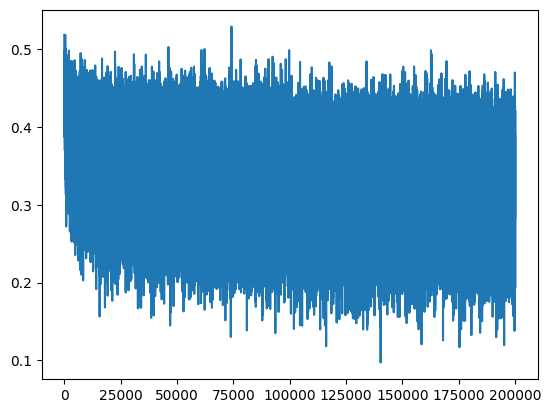

In [163]:
plt.plot(lossi)
#You can see that the plot of the loss dosent have a hockey shape appearance because the loss started small

In [164]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]

    emb = C[X]                                   # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)          # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)              # (N, n_hidden)
    logits = h @ W2 + b2                          # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.100543975830078
val 2.13922119140625


In [ ]:
import time
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))  # decode and print the generated word

tensor(0.0093) tensor(0.9920)
tensor(0.0039) tensor(0.9776)


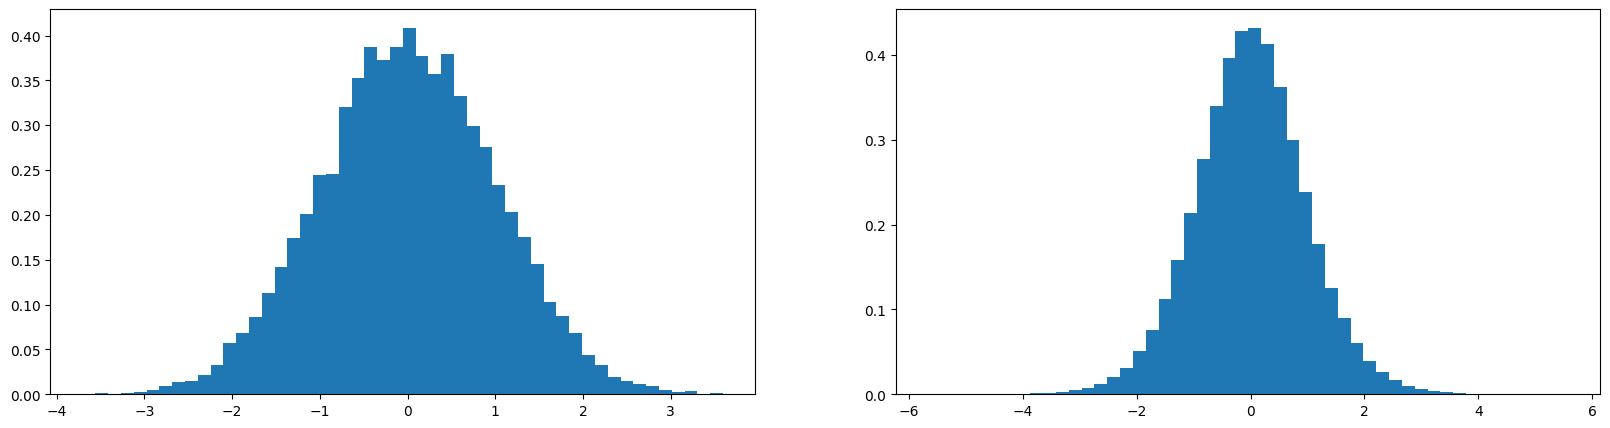

In [166]:
#doing kaiming intializations of the "magic numbers" we used to multiply the weights and biases to fix the saturation of tanh adn initial loss
import torch
import matplotlib.pyplot as plt

# create random tensors
x = torch.randn(1000, 10)
#supopse x and w here are a uniform gaussian 
w = torch.randn(10, 200) / 10**0.5

# matrix multiplication
y = x @ w #if we do x times w what is the mean and the standered deviation of these gaussians
#here the means of these operation remain as same (zero) but the standerd deviation changes quite a bit
#in the figure the gaussian is expanding but throughout the neural nets hidden layers we want the activations to have the same standerd deviation and mean
#intuitively if we multiply the gaussian by some constant then its standerd deviation changes like if you multiply it with a big number its stnaderd deviation increases buut if you multiply it with a number btw (0-1) we will make standerd deviation small
#you are supposed to divide by the square root of (fan_in)
#fan_in is number of incoming activations to the layer of neurons (here its 10) and square rooting it {fan_in has mathematical proof its upon the reader to go and check it out, lmao i anit goin' spoon feed you everything my G}
#and after you do that you get the output gaussian close to or 1
# IN PYTORCH WE INITIALIZED NEURAL NET LIKE THIS 
# YOU have to multiply the layers with a gain for the based on the non linearity you are using like in relu we use gain as 2 because relu says any value below zero will be zero so we have to multiply it by 2 to preserve the to preserve the variance of the activations across layers. (variance and standerd deviation are related basically they are same same but different lmao) 

# torch.nn.init.kaiming_normal_(
#     tensor,
#     a=0,
#     mode='fan_in',
#     nonlinearity='leaky_relu'
# )

# print statistics
print(x.mean(), x.std())
print(y.mean(), y.std())

# plot histograms
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()
